### Build a RFM model for customer segmentation

In [1]:
import pandas as pd
%matplotlib inline
# use the %matplotlib inline command to show plots on the Jupyter Notebook
import matplotlib.pyplot as plt

import mysql.connector as sql

Build the connection with SQL:

In [2]:
db_connection = \
sql.connect(host='wcd-sql-class.c0h2bhc51r9d.us-east-1.rds.amazonaws.com', \
            database='ecommerce', \
            user='student19', password='noisybutter764')

Store your SQL query into a variable:

In [3]:
# if the string has mutiple lines, like below, then >>3 quotation marks<< are required
# query from SQL is also considered as string
query="""
SELECT
  customerid,
  COUNT(distinct invoice) - 1 as frequency,
  datediff(MAX(purchase_dt),MIN(purchase_dt)) as recency,
  sum(quantity*price)/count(distinct invoice) as monetary
FROM onlinetrans
GROUP BY customerid
"""

Execute the query and load the results into Python Pandas: 

(these steps will be very similar to real situation at work)

In [4]:
rfm=pd.read_sql(query, con=db_connection) # using dataframe again, to load SQL query

In [6]:
rfm

,customerid,frequency,recency,monetary
0,12346,11,713,12926.076667
1,12347,7,402,1230.382500
2,12348,4,363,807.760000
3,12349,3,571,2214.345000
4,12350,0,0,668.800000
...,...,...,...,...
5827,18283,21,655,248.786364
5828,18284,0,0,923.360000
5829,18285,0,0,854.000000
5830,18286,1,483,1296.430000


In [6]:
rfm.describe()

,customerid,frequency,recency,monetary
count,5832.000000,5832.000000,5832.000000,5832.000000
mean,15313.884088,5.206276,272.074931,776.106255
std,1716.214965,12.815812,251.545888,2435.608461
min,12346.000000,0.000000,0.000000,0.000000
25%,13829.750000,0.000000,0.000000,356.963333
50%,15313.500000,2.000000,230.000000,562.891364
75%,16796.250000,6.000000,512.000000,836.070000
max,18287.000000,393.000000,718.000000,168472.500000


In [7]:
# rank() computes numerical data ranks (1 through n) along axis
# assign the unique rank
# rank in Ascending order (由小到大)
rfm['r_percentile'] = rfm['recency'].rank(method='first',pct=True,ascending=True)
rfm['r_percentile'].head(10)
# recency的数值 越小越好

0    0.996914
1    0.657064
2    0.596879
3    0.806070
4    0.000171
5    0.000343
6    0.588306
7    0.475480
8    0.000514
9    0.584705
Name: r_percentile, dtype: float64

In [8]:
# split the data into 4 groups, then assign the score 1, 2, 3 or 4
# Quantile-based discretization function. Discretize variable into 
# equal-sized buckets based on rank or based on sample quantiles.
rfm['r_score'] = pd.qcut(rfm['r_percentile'], 4, labels=range(4,0,-1)) 
rfm['r_score'].head(10)

0    1
1    2
2    2
3    1
4    4
5    4
6    2
7    3
8    4
9    2
Name: r_score, dtype: category
Categories (4, int64): [4 < 3 < 2 < 1]

In [9]:
rfm['f_percentile'] = rfm['frequency'].rank(method='first',pct=True,ascending=False)
rfm['f_percentile'].head(10)
# Frequency的数值 越大越好
# rank in Descending order (由大到小)

0    0.107682
1    0.189472
2    0.302298
3    0.363855
4    0.722394
5    0.722565
6    0.145233
7    0.560185
8    0.722737
9    0.560357
Name: f_percentile, dtype: float64

In [10]:
rfm['f_score'] = pd.qcut(rfm['f_percentile'], 4, labels=range(4,0,-1))
rfm['f_score'].head(10)

0    4
1    4
2    3
3    3
4    2
5    2
6    4
7    2
8    2
9    2
Name: f_score, dtype: category
Categories (4, int64): [4 < 3 < 2 < 1]

In [11]:
rfm['m_percentile'] = rfm['monetary'].rank(method='first', pct=True,ascending=False)
rfm['m_score'] = pd.qcut(rfm['m_percentile'], 4, labels=range(4,0,-1))
rfm['m_score'].head(10)
# Monetary的数值 越大越好
# rank in Descending order (由大到小)

0    4
1    4
2    3
3    4
4    3
5    3
6    3
7    2
8    4
9    4
Name: m_score, dtype: category
Categories (4, int64): [4 < 3 < 2 < 1]

In [12]:
rfm.head()

,customerid,frequency,recency,monetary,r_percentile,r_score,f_percentile,f_score,m_percentile,m_score
0,12346,11,713,12926.076667,0.996914,1,0.107682,4,0.001543,4
1,12347,7,402,1230.382500,0.657064,2,0.189472,4,0.107682,4
2,12348,4,363,807.760000,0.596879,2,0.302298,3,0.266804,3
3,12349,3,571,2214.345000,0.806070,1,0.363855,3,0.029321,4
4,12350,0,0,668.800000,0.000171,4,0.722394,2,0.381859,3


add these three score together to get the final score:

In [13]:
rfm['rfm_score'] = rfm.loc[:,['r_score','f_score','m_score']].sum(axis = 1)

In [14]:
rfm.head(20)

,customerid,frequency,recency,monetary,r_percentile,r_score,f_percentile,f_score,m_percentile,m_score,rfm_score
0,12346,11,713,12926.076667,0.996914,1,0.107682,4,0.001543,4,9.0
1,12347,7,402,1230.382500,0.657064,2,0.189472,4,0.107682,4,10.0
2,12348,4,363,807.760000,0.596879,2,0.302298,3,0.266804,3,8.0
3,12349,3,571,2214.345000,0.806070,1,0.363855,3,0.029321,4,8.0
4,12350,0,0,668.800000,0.000171,4,0.722394,2,0.381859,3,9.0
5,12351,0,0,601.860000,0.000343,4,0.722565,2,0.463306,3,9.0
6,12352,9,356,569.968000,0.588306,2,0.145233,4,0.492112,3,9.0
7,12353,1,204,406.760000,0.475480,3,0.560185,2,0.683985,2,7.0
8,12354,0,0,2158.800000,0.000514,4,0.722737,2,0.031893,4,10.0
9,12355,1,353,947.610000,0.584705,2,0.560357,2,0.191529,4,8.0


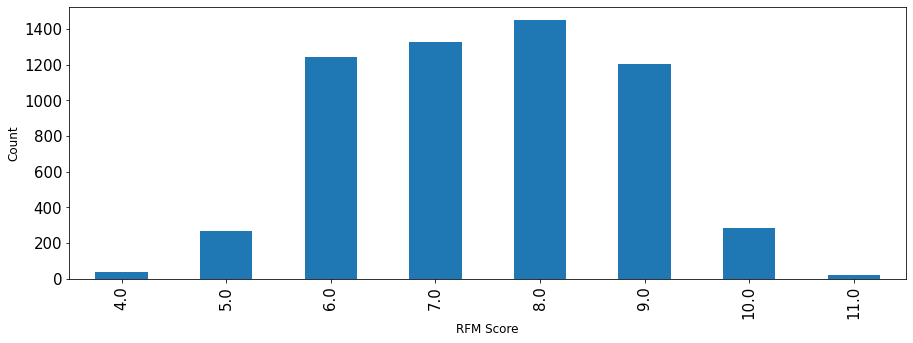

In [15]:
ax = rfm['rfm_score'].value_counts().sort_index().plot(kind='bar', figsize=(15, 5), fontsize=15)
ax.set_xlabel("RFM Score", fontsize=12)
ax.set_ylabel("Count", fontsize=12)
plt.show()

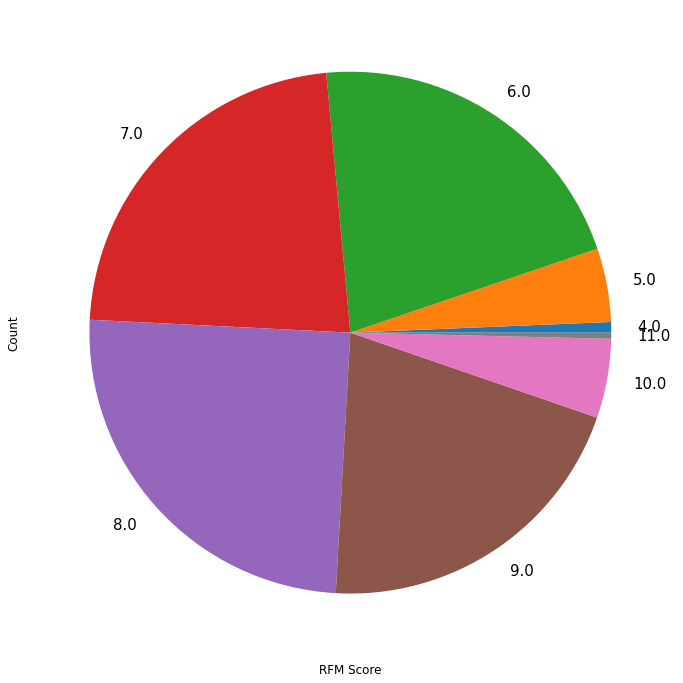

In [16]:
ax = rfm['rfm_score'].value_counts().sort_index().plot(kind='pie', figsize=(15, 12), fontsize=15)
ax.set_xlabel("RFM Score", fontsize=12)
ax.set_ylabel("Count", fontsize=12)
plt.show()

In [17]:
pd.DataFrame(rfm['rfm_score'].value_counts().sort_index())

,rfm_score
4.0,38
5.0,266
6.0,1240
7.0,1326
8.0,1452
9.0,1202
10.0,286
11.0,22


In [18]:
rfm.loc[(rfm['rfm_score']==10) | (rfm['rfm_score']==11),['customerid']]

,customerid
1,12347
8,12354
16,12362
20,12366
22,12368
...,...
5376,17828
5600,18055
5618,18073
5684,18139
